## Course Project:  
# Image Classification - CNN with regularization

This is a notebook to describe a train Deep Learning Model with PyTorch.

The DataSet is not very important. Here, we select Pikachu Web Scappring image from Google

It s a Classification problem with (5)) classes :  bulbasaur, charmander, mewtwo, pikachu, squirtle

Use an pretrain model like ResNet and change the last layer.

Improve with a Drop Out in the last layer

Improve with intelligente Data Augmentation

Improve with different regularization technique


#### Here we have single label per image, witch is important for the functions we have coded


In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from PIL import ImageFile
import torchvision.models as models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from imutils import paths
%matplotlib inline
import glob
import random

import cv2

In [2]:
torch.cuda.empty_cache()
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Parameters

In [3]:
percentage_train_ds = 0.9
batch_size = 32
img_size = 250

## Data Preparation

In [4]:
data_dir = 'dataset'
path_data = data_dir+"/data/"  # dataset split in train_ds and val_ds
path_test = data_dir+"/test/"    # without labels

### Transforme image .png with transparency to RGBA format 



    If raw images are trunced or with transparency, we have to fix it before go on...
    ... here, we have done the job
    Call png_to_jpg function in Convert module.
    

### View classes


In [5]:

classes = os.listdir(path_data)
print('classes : ',classes)
print('name of images : ', os.listdir(path_data + "/pikachu")[:4])

classes :  ['pikachu', 'mewtwo', 'charmander', 'bulbasaur', 'squirtle']
name of images :  ['00000012.jpg', '00000229.jpg', '00000210.jpg', '00000194.jpg']


In [6]:
output = len(classes)
output

5

In [7]:
labels = sorted(list(os.listdir(path_data)))

data_df = pd.DataFrame()
i=0
for label in labels:
    # 1) create dataframe with 2 columns : names of images and classes of images
    images = os.listdir(path_data + label)  
    #{:<12} alignement droit avec une colonne de 6 caractères
    print('{:<6}  {:<12}  {:<4} {:>8}'.format('nb of ', label, ' :', len(images)))
    for image in images:
        data_df.loc[i,'image'] = image
        data_df.loc[i,'label'] = label
        i+=1
        
    # 2) create files for train and val
    try: 
        os.makedirs(path_data + "../train/" + label)
    
    except OSError:
        if not os.path.isdir(path_data + "../train/" + label):
            Raise
    try: 
        os.makedirs(path_data + "../val/" + label)
    
    except OSError:
        if not os.path.isdir(path_data + "../val/" + label):
            Raise
    


nb of   bulbasaur      :        234
nb of   charmander     :        238
nb of   mewtwo         :        239
nb of   pikachu        :        234
nb of   squirtle       :        223


In [8]:
len(data_df)


1168

In [9]:
data_df.head(1068)

,image,label
0,00000012.jpg,bulbasaur
1,00000229.jpg,bulbasaur
2,00000210.jpg,bulbasaur
3,00000194.jpg,bulbasaur
4,00000065.jpg,bulbasaur
...,...,...
1063,00000209.jpg,squirtle
1064,00000040.jpg,squirtle
1065,00000102.jpg,squirtle
1066,00000042.jpg,squirtle


## Train and valid split of the dataframe
names image - classes

In [10]:

np.random.seed(42)
msk = np.random.rand(len(data_df)) < percentage_train_ds

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

In [11]:
print('{:<14} {:>8}'.format('len train_df :', len(train_df)))
print('{:<14} {:>8}'.format('len val_df   :', len(val_df)))

len train_df :     1049
len val_df   :      119


#### create a train file

In [12]:
import shutil
i=0
path_train = data_dir +'/train/'
print(path_train)
try:
    print("copie en cours...")
    for i in range(len(train_df)):
        path=path_data + train_df.loc[i,'label'] + '/' + train_df.loc[i,'image']
        new_path=path_train+ train_df.loc[i,'label'] + '/' + train_df.loc[i,'image']
        
        shutil.copy(path, new_path)
        i+=1
    print("ok...")
        
    
except OSError:
    print("oups..")

print("fin")

dataset/train/
copie en cours...
ok...
fin


#### create a val file

In [13]:
import shutil
i=0
path_val = data_dir +'/val/'

try:
    print("copie en cours...")
    for i in range(len(val_df)):
        path=path_data + val_df.loc[i,'label'] + '/' + val_df.loc[i,'image']
        new_path=path_val+ val_df.loc[i,'label'] + '/' + val_df.loc[i,'image']
        
        shutil.copy(path, new_path)
        i+=1
    print("ok...")
        
    
except OSError:
    print("oups..")

print("fin")


print(path_val)

copie en cours...
ok...
fin
dataset/val/


### Check image
let's check images' 


In [14]:
print("[INFO] Checking train images ")
imgs = []
imagePaths = sorted(list(paths.list_images(path_train)))

for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    try:
        # check could be open
        image = cv2.imread(imagePath)
        
        if image is None:
            print("[INFO] image None {}".format(imagePath))
        #print(image.shape[0])
        if image.shape[0] < img_size or image.shape[1] < img_size :
            print("[INFO] image small{}".format(imagePath))
            print("       image dim ",image.shape[0])
            print("       image dim ",image.shape[1])
    except:
        print("[INFO] image corrompue {}".format(imagePath))
print("[INFO] finish")

        

[INFO] Checking train images 
[INFO] finish


## Creating Datasets & Data Loaders

### Transform Dataset to tensor, Normalize, Data Augmentation

#### Stats for normalization

In [15]:
stats_dummy = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
cifar_stats = ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
mnist_stats = ([0.15, 0.15, 0.15], [0.15, 0.15, 0.15])
    
stats = imagenet_stats


#### Transform function with data augmentation

In [16]:
train_tfms = T.Compose([ 
                         #T.RandomAffine(scale=(0.5,1.1), degrees=(-15,+15),translate=(0.01, 0.12),shear=(0.01, 0.03)),
                         #T.RandomCrop(img_size, padding=8, padding_mode='reflect'),
                         #T.CenterCrop(img_size),
                         T.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.1),
                         T.RandomHorizontalFlip(p=0.1),
                         T.RandomRotation(20),
                         T.Resize([img_size,img_size]),
                         T.ToTensor(), 
                         T.Normalize(*stats,inplace=True),
                         T.RandomErasing(inplace=True)
                        ])
val_test_tfms = T.Compose([T.Resize([img_size,img_size]),
                        T.ToTensor(), 
                        T.Normalize(*stats,inplace=True)
                       ])


#### Pytorch Dataset

In [17]:
data_df.loc[100]

image    00000190.jpg
label       bulbasaur
Name: 100, dtype: object

In [18]:
data_ds = ImageFolder(path_data, train_tfms)
train_ds = ImageFolder(path_train, train_tfms)
val_ds = ImageFolder(path_val, val_test_tfms)
test_ds = ImageFolder(path_test, val_test_tfms)

print('{:<14} {:>8}'.format('len data_ds  :', len(data_ds)))
print('{:<14} {:>8}'.format('len train_ds :', len(train_ds)))
print('{:<14} {:>8}'.format('len val_ds   :', len(val_ds)))
print('{:<14} {:>8}'.format('len test_ds  :', len(test_ds)))

len data_ds  :     1167
len train_ds :     1049
len val_ds   :      245
len test_ds  :        6


In [19]:
data_ds.classes[3]

'pikachu'

In [20]:
train_ds.classes[3]

'pikachu'

#### DataLoaders

In [21]:
# PyTorch data loaders
num_workers=2
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=num_workers, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=num_workers, pin_memory=True)

#### function to show images and batch of images

In [22]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    #print('Label: ', train_ds.classes[label], "("+str(label)+")")
    
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        #data = 1-images if invert else images # ajouter
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

#### Check Dataset and DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


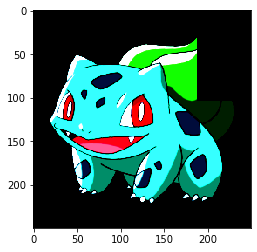

In [23]:
show_sample(*train_ds[0], invert=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


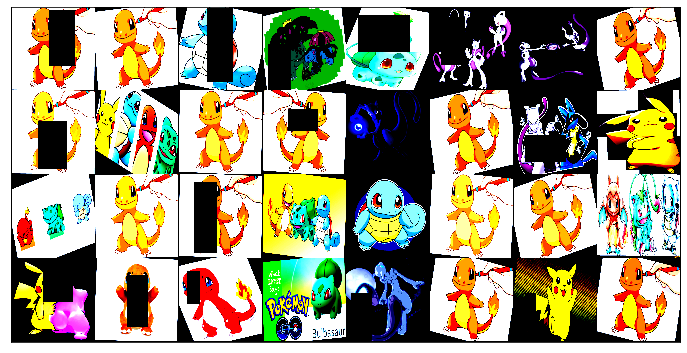

In [24]:
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


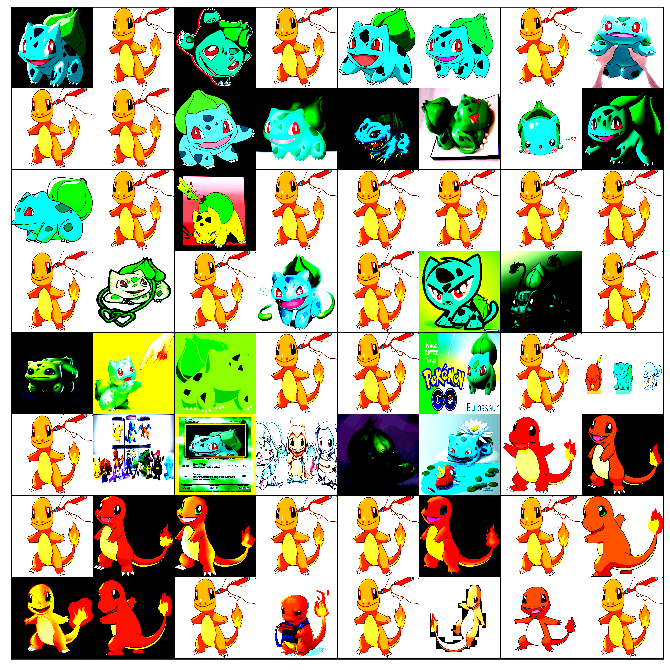

In [25]:
show_batch(val_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


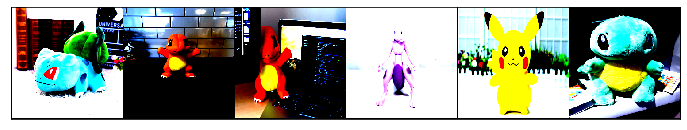

In [26]:
show_batch(test_dl)

Check 

In [27]:
#output=len(train_ds.classes)

print(f"{'Number of images in train dataset:': <40} {len(train_ds):^4}")
print(f"{'Number of images in val dataset:': <40} {len(val_ds):^4}")
print(f"{'Number of images in test dataset:': <40} {len(test_ds):^4}")
print(f"{'Number of training batches :': <40} {len(train_dl):^4}, each of size of {batch_size: ^4}")
print(f"{'Number of val batches :': <40} {len(val_dl):^4}, each of size of {batch_size: ^4}")
print(f"{'Number of test batches :': <40} {len(test_dl):^4}, each of size of {batch_size: ^4}")
print(f"{'Liste of classes in train dataset :': <40} {train_ds.classes}")
print(f"{'Liste of classes in val dataset :': <40} {val_ds.classes}")
print(f"{'Liste of classes in test dataset :': <40} {test_ds.classes}")
print(f"{'Number of classes :': <40} {output}")


Number of images in train dataset:       1049
Number of images in val dataset:         245 
Number of images in test dataset:         6  
Number of training batches :              33 , each of size of  32 
Number of val batches :                   4  , each of size of  32 
Number of test batches :                  1  , each of size of  32 
Liste of classes in train dataset :      ['bulbasaur', 'charmander', 'mewtwo', 'pikachu', 'squirtle']
Liste of classes in val dataset :        ['bulbasaur', 'charmander', 'mewtwo', 'pikachu', 'squirtle']
Liste of classes in test dataset :       ['bulbasaur', 'charmander', 'mewtwo', 'pikachu', 'squirtle']
Number of classes :                      5


Check Tensor
same dim in train_ds and test_ds

In [28]:
print(f"{'Torch size in train dataset :': <40} {train_ds[700][0].shape}")
print(f"{'Torch size in val dataset :': <40} {val_ds[0][0].shape}")
print(f"{'Torch size in test dataset :': <40} {test_ds[3][0].shape}")


Torch size in train dataset :            torch.Size([3, 250, 250])
Torch size in val dataset :              torch.Size([3, 250, 250])
Torch size in test dataset :             torch.Size([3, 250, 250])


check all the tensor

The colors seem out of place because of the normalization
 If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.


In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Model with Transfer Learning

#### Classics functions to calculate loss and score with batch with a single label per image

Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.

In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
   
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
   
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

#### Choose a model pretrain
#### Change the final layer with a classification layer and DropOut layer to reduce the overfitting
#### Prepare freeze and unfreeze function for de weight before final layer



In [33]:

class ResNet_FP(ImageClassificationBase):
    def __init__(self, num_classes:int):
        super().__init__()
        self.network = models.resnet34(pretrained=True) 
        #self.network = models.resnet50(pretrained=True)      
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(nn.Linear(num_ftrs, 256), 
                                        nn.Dropout(0.1), 
                                        nn.ReLU(), 
                                        nn.Linear(256, 64), 
                                        nn.Dropout(0.01), 
                                        nn.ReLU(), 
                                        nn.Linear(64, num_classes))
        
        
    def forward(self, xb):
        #return self.model(xb)
        return torch.softmax(self.network(xb),dim=1)

    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        for param in self.network.parameters():
            param.requires_grad = True


#### Training Functions : fit with regularization


Before we train the model, we're going to make a bunch of small but important improvements to our fit function:

#### Learning rate scheduling: 
Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. 

#### Weight decay: 
We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

#### Gradient clipping: 
Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. 

Let's define a fit_one_cycle function to incorporate these changes. 
We'll also record the learning rate used for each batch.

In [34]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader),
                                                cycle_momentum=True)
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        #for batch in tqdm(train_loader):
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [35]:
#model = to_device(Pikachu_nn(), device)
model = to_device(ResNet_FP(num_classes=5), device)
model

ResNet_FP(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

### Utils functions

In [36]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([32, 3, 250, 250])
out.shape: torch.Size([32, 5])
out[0]: tensor([0.1989, 0.1876, 0.2076, 0.2088, 0.1971], device='cuda:0',
       grad_fn=<SelectBackward>)


In [37]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [38]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [39]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

## Training

In [40]:
torch.cuda.empty_cache()
lrs = []
epochs_list = []
train_times = []

In [41]:
#history = [evaluate(model, val_dl)]
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.608046293258667, 'val_acc': 0.28213441371917725}]

First, freeze the ResNet layers and train some epochs. This only trains the final layer to start classifying the images.

In [42]:
#model.freeze()
model.unfreeze()

In [43]:
epochs = 10 #10
max_lr = 0.005
grad_clip = None
weight_decay = 0
opt_func = torch.optim.Adam

# Logging the hyper-parameters
lrs.append(max_lr)
epochs_list.append(epochs)

In [44]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00136, train_loss: 1.4214, val_loss: 1.4931, val_acc: 0.4077
Epoch [1], last_lr: 0.00378, train_loss: 1.5399, val_loss: 1.7182, val_acc: 0.1204
Epoch [2], last_lr: 0.00500, train_loss: 1.6107, val_loss: 1.5606, val_acc: 0.3142
Epoch [3], last_lr: 0.00475, train_loss: 1.5610, val_loss: 1.5526, val_acc: 0.2220
Epoch [4], last_lr: 0.00406, train_loss: 1.5511, val_loss: 1.5073, val_acc: 0.3796
Epoch [5], last_lr: 0.00306, train_loss: 1.5691, val_loss: 1.5663, val_acc: 0.2600
Epoch [6], last_lr: 0.00194, train_loss: 1.5710, val_loss: 1.5450, val_acc: 0.2836
Epoch [7], last_lr: 0.00094, train_loss: 1.5385, val_loss: 1.4898, val_acc: 0.4039
Epoch [8], last_lr: 0.00025, train_loss: 1.5270, val_loss: 1.4835, val_acc: 0.4086
Epoch [9], last_lr: 0.00000, train_loss: 1.5274, val_loss: 1.4842, val_acc: 0.4102
CPU times: user 30.4 s, sys: 11.3 s, total: 41.7 s
Wall time: 14min 58s


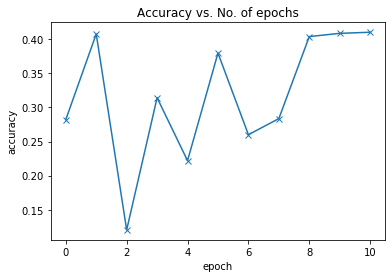

In [45]:
plot_scores(history)

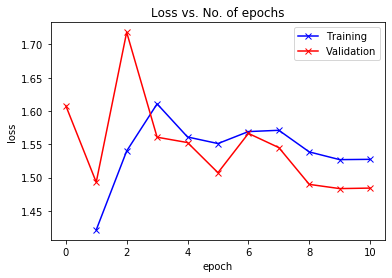

In [46]:
plot_losses(history)

Now, unfreeze and train some more.

In [47]:
model.unfreeze()
#model.switch_on_gradients()
model

ResNet_FP(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [48]:
weights_fname = 'Course-Project-FabienFP-run1.pth'
torch.save(model.state_dict(), weights_fname)

In [49]:
epochs = 20 #20
max_lr = 0.001
grad_clip = 0.05
weight_decay = 1e-4
opt_func = torch.optim.Adam

# Logging the hyper-parameters
lrs.append(max_lr)
epochs_list.append(epochs)

In [50]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00010, train_loss: 1.5224, val_loss: 1.4740, val_acc: 0.4298
Epoch [1], last_lr: 0.00028, train_loss: 1.5143, val_loss: 1.4800, val_acc: 0.4399
Epoch [2], last_lr: 0.00052, train_loss: 1.5061, val_loss: 1.4746, val_acc: 0.4578
Epoch [3], last_lr: 0.00076, train_loss: 1.5113, val_loss: 1.4533, val_acc: 0.4262
Epoch [4], last_lr: 0.00094, train_loss: 1.4555, val_loss: 1.5024, val_acc: 0.3945
Epoch [5], last_lr: 0.00100, train_loss: 1.4943, val_loss: 1.5036, val_acc: 0.3547
Epoch [6], last_lr: 0.00099, train_loss: 1.4840, val_loss: 1.5423, val_acc: 0.3125
Epoch [7], last_lr: 0.00095, train_loss: 1.4569, val_loss: 1.5236, val_acc: 0.3643
Epoch [8], last_lr: 0.00089, train_loss: 1.4785, val_loss: 1.4070, val_acc: 0.5270
Epoch [9], last_lr: 0.00081, train_loss: 1.4243, val_loss: 1.3848, val_acc: 0.5085
Epoch [10], last_lr: 0.00072, train_loss: 1.3970, val_loss: 1.3555, val_acc: 0.5538
Epoch [11], last_lr: 0.00061, train_loss: 1.4041, val_loss: 1.3614, val_acc: 0.5296
Ep

In [51]:
weights_fname = 'Course-Project-FabienFP-run2.pth'
torch.save(model.state_dict(), weights_fname)

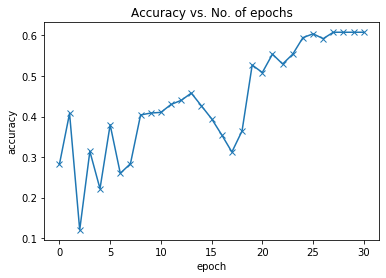

In [52]:
plot_scores(history)

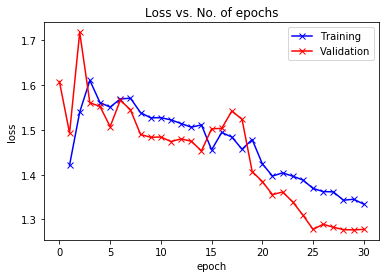

In [53]:
plot_losses(history)

In [54]:
epochs = 20 #20
max_lr = 0.001
grad_clip = 0.05
weight_decay = 1e-4
opt_func = torch.optim.Adam

# Logging the hyper-parameters
lrs.append(max_lr)
epochs_list.append(epochs)

In [55]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00010, train_loss: 1.3402, val_loss: 1.2872, val_acc: 0.5945
Epoch [1], last_lr: 0.00028, train_loss: 1.3436, val_loss: 1.2931, val_acc: 0.5968
Epoch [2], last_lr: 0.00052, train_loss: 1.3518, val_loss: 1.2842, val_acc: 0.6086
Epoch [3], last_lr: 0.00076, train_loss: 1.3649, val_loss: 1.3352, val_acc: 0.5686
Epoch [4], last_lr: 0.00094, train_loss: 1.3490, val_loss: 1.2852, val_acc: 0.6015
Epoch [5], last_lr: 0.00100, train_loss: 1.3591, val_loss: 1.3310, val_acc: 0.5427
Epoch [6], last_lr: 0.00099, train_loss: 1.3845, val_loss: 1.3191, val_acc: 0.5781
Epoch [7], last_lr: 0.00095, train_loss: 1.3737, val_loss: 1.3880, val_acc: 0.4974
Epoch [8], last_lr: 0.00089, train_loss: 1.3913, val_loss: 1.3741, val_acc: 0.5058
Epoch [9], last_lr: 0.00081, train_loss: 1.4162, val_loss: 1.3572, val_acc: 0.5325
Epoch [10], last_lr: 0.00072, train_loss: 1.3629, val_loss: 1.3140, val_acc: 0.5828
Epoch [11], last_lr: 0.00061, train_loss: 1.3553, val_loss: 1.3002, val_acc: 0.5836
Ep

In [56]:
weights_fname = 'Course-Project-FabienFP-run3.pth'
torch.save(model.state_dict(), weights_fname)

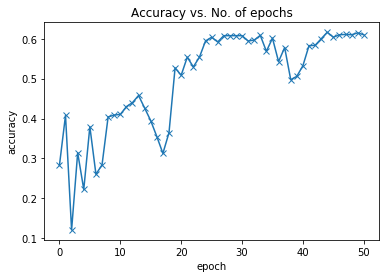

In [57]:
plot_scores(history)

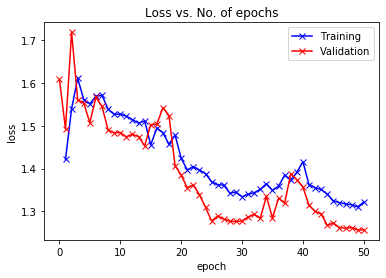

In [58]:
plot_losses(history)

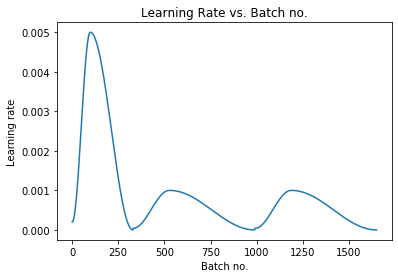

In [59]:
plot_lrs(history)

## Testing with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by creating a test dataset using the ImageFolder class.

In [60]:
test_ds # already done

Dataset ImageFolder
    Number of datapoints: 6
    Root location: dataset/test/
    StandardTransform
Transform: Compose(
               Resize(size=[250, 250], interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [61]:
def predict_image(img, model, dataset):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bulbasaur , Predicted: bulbasaur


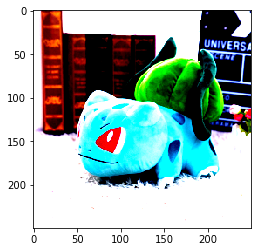

In [62]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model, test_ds))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: mewtwo , Predicted: mewtwo


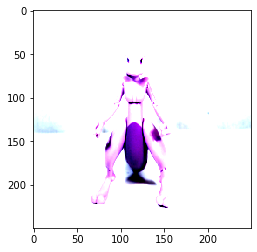

In [63]:
img, label = test_ds[3]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model, test_ds))

As a final step, let's also look at the overall loss and accuracy of the model on the test set, 

In [64]:
#pas de label sur le test .....

In [65]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.082382082939148, 'val_acc': 0.8333333134651184}

In [66]:
evaluate(model, val_dl)

{'val_loss': 1.2569576501846313, 'val_acc': 0.6101120114326477}

# Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights of the model to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.


### Save

In [67]:
weights_fname = 'Course-Project-FabienFP_final.pth'
torch.save(model.state_dict(), weights_fname)

### Load

In [68]:
model_load = to_device(ResNet_FP(num_classes=5), device)

In [69]:
model_load.load_state_dict(torch.load('Course-Project-FabienFP_final.pth'))

<All keys matched successfully>

Check

In [70]:
evaluate(model_load, test_loader)

{'val_loss': 1.082382082939148, 'val_acc': 0.8333333134651184}